# ⚙️🛠️ DOTA Data Preprocessing

The raw extracted data can be found in the [YASP.CO](https://academictorrents.com/details/5c5deeb6cfe1c944044367d2e7465fd8bd2f4acf) collection from Academic Torrents. This was uploaded and gathered by [Albert Cui](https://academictorrents.com/browse.php?search=Albert+Cui) et. al (2015). 

It's important to know that since the data was gathered from [OpenDota API](https://www.opendota.com/api-keys) from different endpoints, this will require a serious merge. In case you prefer not to use the API, you can request the data using this [interface](https://www.opendota.com/explorer?minDate=2022-05-19T16%3A46%3A04.380Z).

Many different endpoints were used to gather the respective JSON files. Fortunately, we have them already transformed from dictionaries into data frames after the author extracted the keys needed.

If you want a similarly structured data frame, you can access this example by [Devin Anzelmo](https://www.kaggle.com/datasets/devinanzelmo/dota-2-matches?datasetId=273&sortBy=voteCount&select=players.csv).

Also, you can access the data description from [here](https://wiki.teamfortress.com/wiki/WebAPI/GetMatchDetails#Tower_Status%22tower_status_dire%22:%202047).

For our first data setting-up process, we'll consider the next points:

- The variables to subset will be only associated with in-session metrics and all kinds of historical metrics won't be included.

- Anonymized Account Ids (value of 0), will be excluded since we require them to join the data with the rest of the datasets.

- At the end of this notebook will be an Appendix with the description of each variable.

First, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np

Also, a function to count NA values can be useful.

In [2]:
# Function the plot a summary of missing values
def nullCounter(data):
    # Create empty lists
    columns = []
    nulls = []
    perc = []
    total_rows = data.shape[0]

    for i in range(len(data.columns)):
        # Null values
        null_counter = data.loc[:,data.columns[i]].isnull().sum()

        # Append only columns with null values
        if null_counter > 0:
            # Append values to lists
            columns.append(data.columns[i])
            nulls.append(null_counter)

            # Generate percentage
            perc_value = null_counter/total_rows
            perc.append("{:.2%}".format(perc_value))

    # Create DF from lists
    df = pd.DataFrame({'Null Values':nulls, 'Fraction':perc}).T
    # Set columns
    df.columns = columns

    return df

First, let's read the datasets.

## 🧝 Player Data (Main Table)

This table contains around 320,000 records of matches played by different users (accounts), with many descriptive and quantitative gameplay metrics by player and session.

In [3]:
players = pd.read_csv("DOTA_data/players.csv")

nullCounter(data= players).T.sort_values(by='Fraction', ascending=False)

,Null Values,Fraction
unit_order_move_to_direction,496449,99.29%
unit_order_disassemble_item,485446,97.09%
gold_abandon,479366,95.87%
unit_order_eject_item_from_stash,468736,93.75%
unit_order_cast_toggle_auto,463670,92.73%
unit_order_stop,412425,82.48%
gold_killing_couriers,403021,80.60%
unit_order_cast_toggle,401211,80.24%
unit_order_give_item,394631,78.93%
gold_buyback,352859,70.57%


From this, as a standard, we will trim those variables with more than 50% of Null values, and all the account_id with a value of zero.

In [4]:
# Drop anonymized account ids, 35% of total
players = players[players.account_id != 0]

# Not required columns with more than 50% of NA values
subset_col = [i for i in players.columns if ("unit_order_" not in i) and ("gold_" not in i) and ("xp_" not in i)]
# Appending some exceptions
subset_col.extend(["gold_per_min","xp_per_min"])
players = players[subset_col] 

# Convert stuns to number
players.stuns = [0 if i == "None" else round(float(i),0) for i in players.stuns]

Let's map the player side as well. Where we will take the player slot 8-bit encryption number to transform it into the required columns. You can read more about the source in the Appendix.

In [5]:
try:
    n = [0,1,2,3,4,128,129,130,131,132]
    side = ["Radiant","Radiant","Radiant","Radiant","Radiant","Dire","Dire","Dire","Dire","Dire"]
    role = ["Hard_Carry","Mid","Offlaner","Soft_Support","Hard_Support","Hard_Carry","Mid","Offlaner","Soft_Support","Hard_Support"]
    lane = ["Safelane","Midlane","Offlane","Offlane","Safelane","Safelane","Midlane","Offlane","Offlane","Safelane"]

    # Side Set-up
    side_lookup = {str(n[x]):side[x] for x in range(len(n))}
    players["side"] = pd.Series([str(i) for i in players["player_slot"]]).map(side_lookup)

    # Role Set-up
    role_lookup = {str(n[x]):role[x] for x in range(len(n))}
    players["role"] = pd.Series([str(i) for i in players["player_slot"]]).map(role_lookup)

    # Lane Set-up
    lane_lookup = {str(n[x]):lane[x] for x in range(len(n))}
    players["lane"] = pd.Series([str(i) for i in players["player_slot"]]).map(lane_lookup)

    # Remove player slot
    players = players.drop(columns=["player_slot"], axis = 1)
except:
    print("")

players.head()

,match_id,account_id,hero_id,gold,kills,deaths,assists,denies,last_hits,stuns,...,item_3,item_4,item_5,level,leaver_status,gold_per_min,xp_per_min,side,role,lane
1,0,1,51,2954,13,3,18,9,109,87.0,...,102,24,108,22,0,494,659,Radiant,Soft_Support,Offlane
3,0,2,11,1179,8,4,19,6,271,0.0,...,164,79,160,21,0,599,605,Dire,Hard_Carry,Safelane
4,0,3,67,3307,20,3,17,13,245,0.0,...,0,137,63,24,0,613,762,Dire,Offlaner,Offlane
5,0,4,106,476,5,6,8,5,162,0.0,...,48,212,0,19,0,397,524,Dire,Hard_Support,Safelane
7,0,5,46,2390,4,8,6,31,208,0.0,...,147,168,21,19,0,452,517,Radiant,Soft_Support,Offlane


## 🦸‍♀️ Hero names

This one is an identifier table, from which we'll extract the Hero names later.

In [6]:
hero_names = pd.read_csv("DOTA_data/hero_names.csv")
hero_names = hero_names.drop(columns=["name"])
hero_names.columns = ["hero_id","hero_name"]
hero_names.head()

,hero_id,hero_name
0,1,Anti-Mage
1,2,Axe
2,3,Bane
3,4,Bloodseeker
4,5,Crystal Maiden


## ⚗️ Joining Hero and Items to Players CSV

We need to merge the hero names to the players' data using a left join.

In [7]:
try:
    hero_names.hero_name = [i.replace(" ","_") for i in hero_names.hero_name]
    players = pd.merge(players, hero_names, how="left", on=["hero_id"])
    players = players.drop(columns=["hero_id"])
except:
    print("")

Then we start mapping the items from a premade dictionary, to make it easier.

In [8]:
item_ids = pd.read_csv("DOTA_data/item_ids.csv")

# Item dictionary
item_lookup = {str(item_ids.item_id[x]):item_ids.item_name[x] for x in range(item_ids.shape[0])}               

try:
    for i in range(6):
        slot = 'item_'+str(i)
        players[slot] = pd.Series([str(i) for i in players[slot]]).map(item_lookup)
except:
    print("")

## 🏆 Merge match outcomes

We are going to join our outcome data at match level to classify the players' result by match

In [9]:
matches = pd.read_csv('DOTA_data/match.csv')
# Subset required columns only
matches = matches[['match_id','radiant_win']]
# Map match outcome
matches['match_winner'] = matches['radiant_win'].map({True:'Radiant',False:'Dire'})
# Drop unused columns
matches.drop(columns='radiant_win', axis=1, inplace= True)
# Merge match outcomes
players = pd.merge(players, matches, on= ['match_id'], how= 'left')
# Check if player is on the winner side
players['victory'] = [ 1 if (players['side'][i] == players['match_winner'][i]) else 0 for i in range(players.shape[0])]
# Sort columns
players = players.loc[:,sorted(players.columns)]

players.head()

,account_id,assists,deaths,denies,gold,gold_per_min,hero_damage,hero_healing,hero_name,item_0,...,leaver_status,level,match_id,match_winner,role,side,stuns,tower_damage,victory,xp_per_min
0,1,18,3,9,2954,494,23747,0,Clockwerk,tpscroll,...,0,22,0,Radiant,Soft_Support,Radiant,87.0,423,1,659
1,2,19,4,6,1179,599,14832,2714,Shadow_Fiend,power_treads,...,0,21,0,Radiant,Hard_Carry,Dire,0.0,6055,0,605
2,3,17,3,13,3307,613,33740,243,Spectre,heart,...,0,24,0,Radiant,Offlaner,Dire,0.0,1833,0,762
3,4,8,6,5,476,397,10725,0,Ember_Spirit,bfury,...,0,19,0,Radiant,Hard_Support,Dire,0.0,112,0,524
4,5,6,8,31,2390,452,10230,0,Templar_Assassin,bottle,...,0,19,0,Radiant,Soft_Support,Radiant,0.0,2438,1,517


## 📊 Distribution Check

Before discarding outliers it's important to verify the distribution of the data.

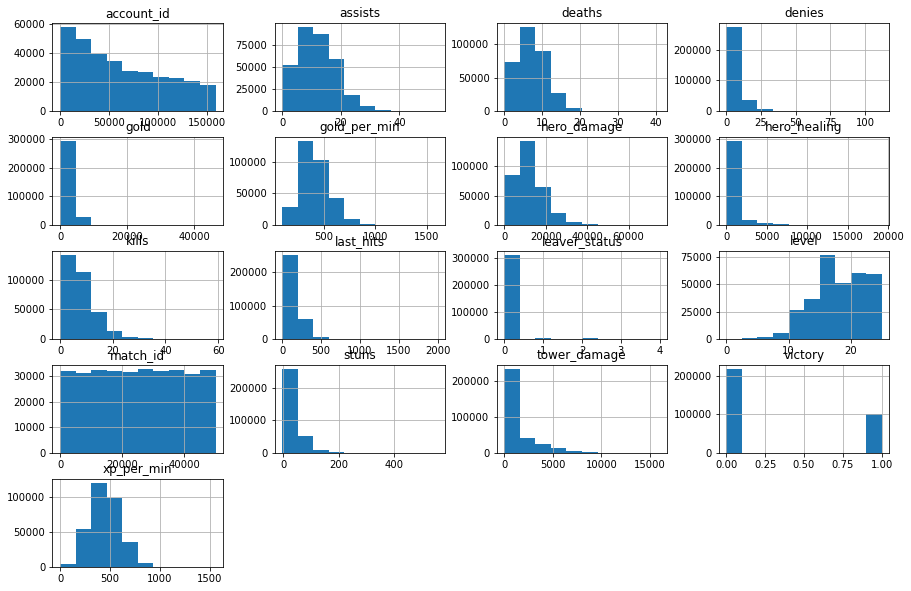

In [10]:
# Histogram grid from https://stackoverflow.com/questions/29530355/plotting-multiple-histograms-in-grid
def draw_histograms(data):
    # Extract columns with numeric values
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    # Subset numeric variables
    df = data.select_dtypes(include=numerics)
    # Generate grid
    df.hist(figsize= (15,10), bins= 10)

draw_histograms(data= players)

In [11]:
players.describe(include='number', percentiles= [.5, 0.95, 0.99])

,account_id,assists,deaths,denies,gold,gold_per_min,hero_damage,hero_healing,kills,last_hits,leaver_status,level,match_id,stuns,tower_damage,victory,xp_per_min
count,318831.000000,318831.000000,318831.000000,318831.000000,318831.000000,318831.000000,318831.000000,318831.000000,318831.000000,318831.000000,318831.000000,318831.000000,318831.000000,318831.000000,318831.000000,318831.000000,318831.000000
mean,62086.169497,11.828414,7.482472,5.552302,1938.360489,419.316026,12238.794480,488.579376,7.386324,132.043195,0.035599,18.011636,25028.212015,26.443445,1359.240510,0.318987,451.268271
std,45082.989563,6.424468,3.778526,6.174821,1776.200220,141.789934,6781.190453,1245.088763,5.448544,104.185820,0.266394,4.392173,14404.532666,34.233302,1860.049124,0.466085,148.494959
min,1.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.000000,0.000000,0.000000,0.000000
50%,53641.000000,11.000000,7.000000,4.000000,1396.000000,398.000000,10909.000000,0.000000,6.000000,107.000000,0.000000,18.000000,25102.000000,11.000000,569.000000,0.000000,443.000000
95%,144029.500000,23.000000,14.000000,18.000000,5468.000000,675.000000,25193.000000,2988.000000,18.000000,333.000000,0.000000,25.000000,47438.500000,95.000000,5500.000000,1.000000,704.000000
99%,155395.700000,30.000000,17.000000,28.000000,7681.000000,826.000000,33029.800000,6232.700000,24.000000,477.000000,1.000000,25.000000,49475.000000,143.000000,8152.700000,1.000000,814.000000
max,158360.000000,53.000000,41.000000,112.000000,46424.000000,1601.000000,74932.000000,19222.000000,59.000000,2000.000000,4.000000,25.000000,49999.000000,555.000000,15986.000000,1.000000,1559.000000


From the numeric attributes percentiles, we can conclude the next about our desired subset.

In [12]:
# assists: 98% of the players has less than 27 assits and there are outliers with more than 53 so we will exclude those above 30
players.drop(players[(players['assists'] > 30)].index, inplace = True)
# deaths: Values above 17 will be excluded
players.drop(players[(players['deaths'] > 17)].index, inplace = True)
# denies: Values above 28 will be excluded
players.drop(players[(players['denies'] > 28)].index, inplace = True)
# gold: Values above 7681 will be excluded
players.drop(players[(players['gold'] > 7681)].index, inplace = True)
# gold_per_min: Values above 826 will be excluded
players.drop(players[(players['gold_per_min'] > 826)].index, inplace = True)
# hero_damage: Values above 33030 will be excluded
players.drop(players[(players['hero_damage'] > 33030)].index, inplace = True)
# hero_healing: Values above 6238 will be excluded
players.drop(players[(players['hero_healing'] > 6238)].index, inplace = True)
# kills: Values above 24 will be excluded
players.drop(players[(players['kills'] > 24)].index, inplace = True)
# last_hits: Values above 477 will be excluded
players.drop(players[(players['last_hits'] > 477)].index, inplace = True)
# stuns: Values above 143 and below 0 will be excluded
players.drop(players[(players['stuns'] > 143)].index, inplace = True)
players.drop(players[(players['stuns'] < 0)].index, inplace = True)
# tower_damage: Values above 8153 will be excluded
players.drop(players[(players['tower_damage'] > 8153)].index, inplace = True)
# xp_per_min: Values above 814 will be excluded
players.drop(players[(players['xp_per_min'] > 814)].index, inplace = True)

# Let's check the data
players.describe(include='number', percentiles= [.5, 0.95, 0.99])

,account_id,assists,deaths,denies,gold,gold_per_min,hero_damage,hero_healing,kills,last_hits,leaver_status,level,match_id,stuns,tower_damage,victory,xp_per_min
count,290106.000000,290106.000000,290106.000000,290106.000000,290106.000000,290106.000000,290106.000000,290106.00000,290106.000000,290106.000000,290106.000000,290106.000000,290106.000000,290106.000000,290106.000000,290106.000000,290106.000000
mean,62277.313606,11.486550,7.468449,5.179662,1788.729788,404.881654,11551.364732,427.02455,6.874684,121.767947,0.038083,17.621518,25021.295926,25.367962,1174.005443,0.318966,439.442238
std,45094.753492,6.103855,3.602152,5.383229,1567.746171,124.937519,5971.720626,1005.56325,4.850024,89.182496,0.276014,4.267350,14408.574481,31.147768,1575.158752,0.466077,140.323124
min,1.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,53904.000000,11.000000,7.000000,3.000000,1311.000000,391.000000,10498.500000,0.00000,6.000000,101.000000,0.000000,18.000000,25077.000000,11.000000,511.000000,0.000000,434.000000
95%,144106.000000,23.000000,14.000000,17.000000,5026.000000,631.000000,23112.750000,2694.00000,16.000000,299.000000,0.000000,25.000000,47440.750000,90.000000,4788.000000,1.000000,678.000000
99%,155427.950000,27.000000,16.000000,24.000000,6587.950000,726.000000,28467.950000,4996.00000,21.000000,399.000000,1.000000,25.000000,49477.000000,122.000000,6829.950000,1.000000,760.000000
max,158360.000000,30.000000,17.000000,28.000000,7681.000000,826.000000,33027.000000,6238.00000,24.000000,477.000000,4.000000,25.000000,49999.000000,143.000000,8153.000000,1.000000,814.000000


Finally, let's save our final dataframe.

In [13]:
players.to_csv('DOTA_data/data.csv', encoding='utf-8', index=True)
players.sample(frac= 0.30).to_csv('DOTA_data/data_sampled.csv', encoding='utf-8', index=True)

---

# 📕 Appendix

## How many times can I die in DOTA?

Many times, but the main intention is not to be spending on buybacks after death or to lost Unreliable Gold. Because when spending gold the game will spend Unreliable Gold first before spending Reliable Gold, except in the case of buybacks where reliable gold will be deducted first

## How long is a DOTA session?

Usually Between 30 Minutes and an hour


## Variable descriptions

- match_id: Match ID

- account_id: 32-bit account ID

- hero_id: Hero ID

- player_slot: A player's slot is returned via an 8-bit unsigned integer. The first bit represent the player's team, false if Radiant and true if dire. The final three bits represent the player's position in that team, from 0-4
```
┌─────────────── Team (false if Radiant, true if Dire).
│ ┌─┬─┬─┬─────── Not used.
│ │ │ │ │ ┌─┬─┬─ The position of a player within their team (0-4).
│ │ │ │ │ │ │ │
0 0 0 0 0 0 0 0
```
- gold: Currency earned by killing heroes, creeps, or buildings

- gold_spent: Gold used to buy items or instantly revive your hero

- gold_per_min: The player's overall gold/minute

- xp_per_min: The player's overall experience/minute

- kills: The amount of kills attributed to this player

- deaths: The amount of times this player died during the match

- assists: The amount of assists attributed to this player

- denies: Killing your allied unit, hero or building, in order to prevent an enemy from gaining the gold and experience it gives. You can manually attack your own creeps if their health is below 50%, your own towers below if they are below 10%, and heroes affected by certain DoTs. A hero can also be said to be denied if they die to neutral creeps instead of to an enemy unit

- last_hits: Last-hitting is a technique where you (or a creep under your control) get the final blow on a neutral creep, enemy lane creep, enemy hero or building. The hero that dealt the killing blow to the enemy unit will be awarded with gold and experience

- stuns: Stun is a status effect that completely locks down affected units, disabling almost all of its capabilities

- hero_damage: Damage dealt to enemy heroes

- hero_healing: Healing provided to friendly heroes

- tower_damage: Damage dealt to enemy building (towers and barracks)

- item_0: ID of the top-left inventory item

- item_1: ID of the top-center inventory item

- item_2: ID of the top-right inventory item

- item_3: ID of the bottom-left inventory item

- item_4: ID of the bottom-center inventory item

- item_5: ID of the bottom-right inventory item

- level: Level of the hero

- leaver_status: 0 for None, 1 for disconnected, 2 for disconnected too long, 3 for abandoned

1 - Player disconnected

2 - Player disconnected, left for longer than 5 mins, and is counted as abandoned

3 - Player disconnected, and manually clicked on leave game, counted as abandon

4 - Player is afk (no xp in certain time period)

- xp_hero: Experience gathered from hero kills

- xp_creep: Experience gathered from creep kills

- xp_other: Experience gathered from other sources

- gold_other: Gold gathered from other sources

- gold_death: Gold gathered from deaths

- gold_sell: Gold gathered from selling

- gold_destroying_structure: Gold gathered from structures destroyed

- gold_killing_heros: Gold gathered from heroes killed

- gold_killing_creeps: Gold gathered from creeps killed
